## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib.colors import (
    Colormap,
    ListedColormap,
)

sns.set(style = "whitegrid")
warnings.filterwarnings("ignore")

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [12]:
from sklearn.datasets import (
    make_moons,
    make_circles,
    make_classification,
)

datasets = [
    make_circles(
        noise                 = 0.2,
        factor                = 0.5,
        random_state          = 42,
    ),

    make_moons(
        noise                 = 0.2, 
        random_state          = 42,
    ),

    make_classification(
        n_classes             = 3,
        n_clusters_per_class  = 1,
        n_features            = 2,
        class_sep             = 0.8,
        random_state          = 3,
        n_redundant           = 0,
    ),
]

In [13]:
palette   = sns.color_palette(n_colors = 3)
cmap      = ListedColormap(palette)

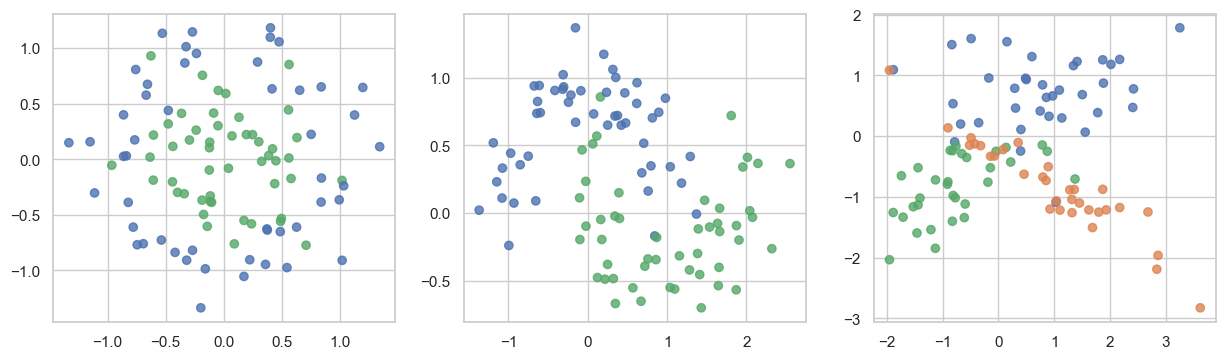

In [14]:
plt.figure(figsize = (15, 4))
for (i, (x, y)) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)

    plt.scatter(
        x[ : , 0], x[ : , 1],
        c         = y,
        cmap      = cmap,
        alpha     = 0.8,
    )

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [15]:
def plot_surface(clf, X, y):
    plot_step        = 0.01
    palette          = sns.color_palette(n_colors = len(np.unique(y)))
    cmap             = ListedColormap(palette)
    x_min, x_max     = X[ : , 0].min() - 1, X[ : , 0].max() + 1
    y_min, y_max     = X[ : , 1].min() - 1, X[ : , 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step),
        np.arange(y_min, y_max, plot_step),
    )

    plt.tight_layout(
        h_pad        = 0.5,
        w_pad        = 0.5,
        pad          = 2.5,
    )

    Z   = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z   = Z.reshape(xx.shape)

    cs = plt.contourf(
        xx, yy, Z,
        cmap         = cmap,
        alpha        = 0.3,
    )

    plt.scatter(
        X[ : , 0], X[ : , 1],
        c            = y,
        cmap         = cmap,
        alpha        = 0.7,
        edgecolors   = np.array(palette)[y],
        linewidths   = 2.0,
    )

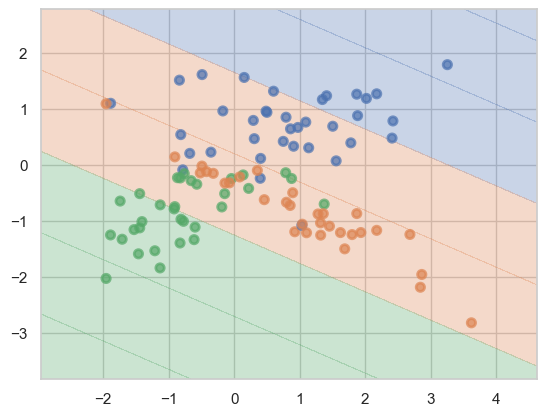

In [16]:
# Пример:
from sklearn.linear_model import LinearRegression

X, y    = datasets[2]
lr      = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

     Данные  Train  Test  Разница  Глубина
0     Круги  1.000 0.700    0.300        6
1    Месяцы  1.000 0.933    0.067        6
2  3 класса  1.000 0.933    0.067        3


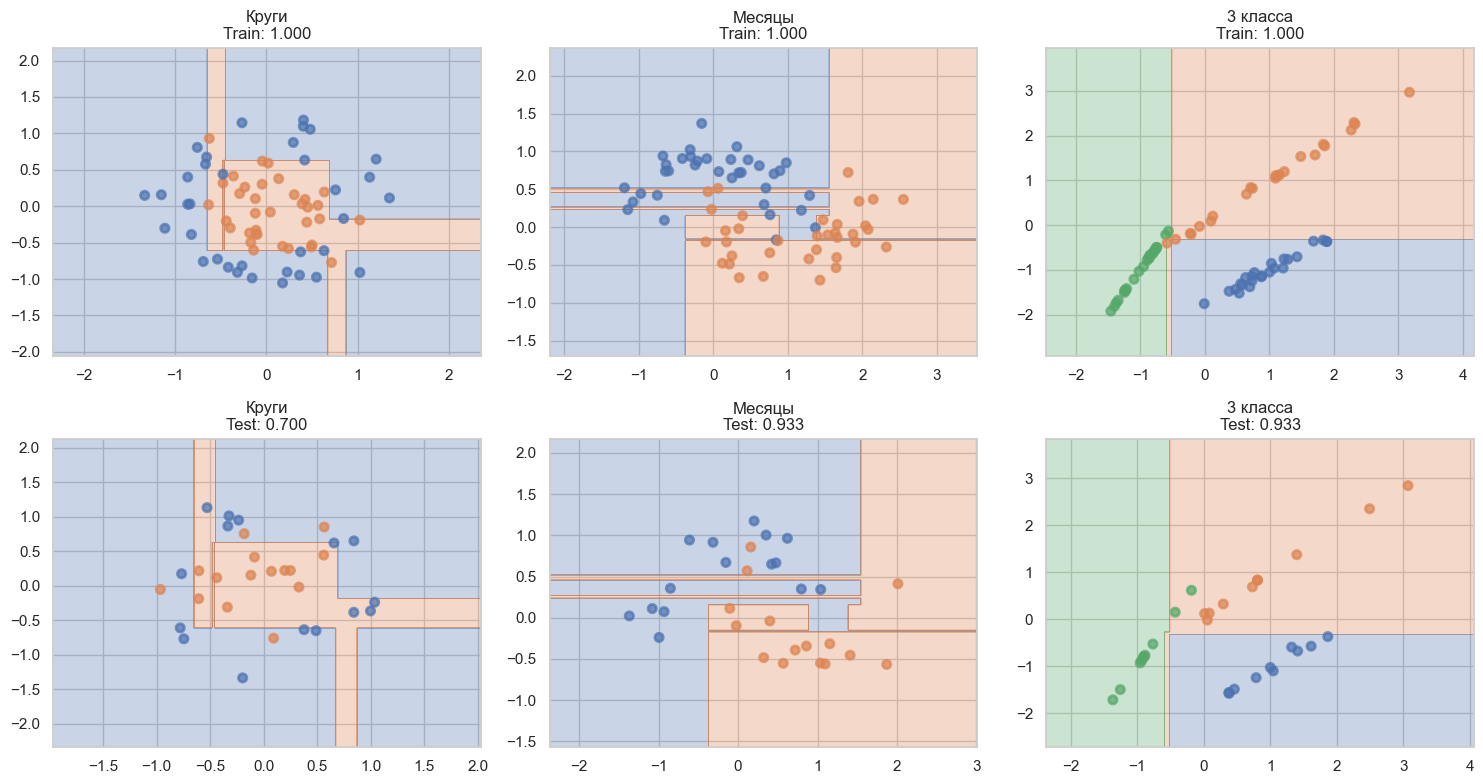

In [17]:
from sklearn.metrics import accuracy_score

from sklearn.datasets import (
    make_moons,
    make_circles,
    make_classification,
)

# Параметры
SEED             = 42
TEST_SIZE        = 0.3

names            = [
                        "Круги",
                        "Месяцы",
                        "3 класса",
                   ]

results          = []

# Создание данных
datasets = [
    make_circles(
        noise                 = 0.2,
        factor                = 0.5,
        random_state          = SEED,
    ),

    make_moons(
        noise                 = 0.2,
        random_state          = SEED,
    ),

    make_classification(
        n_classes             = 3,
        n_features            = 2,
        n_redundant           = 0,
        n_clusters_per_class  = 1,
        random_state          = SEED,
    ),
]

plt.figure(figsize = (15, 8))

for (index, ((X, y), name)) in enumerate(zip(datasets, names)):
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size     = TEST_SIZE,
        random_state  = SEED,
        stratify      = y,
    )

    # Обучение модели
    model = DecisionTreeClassifier(random_state = SEED)
    model.fit(X_train, y_train)

    # Оценка качества
    train_accuracy    = accuracy_score(y_train, model.predict(X_train))
    test_accuracy     = accuracy_score(y_test, model.predict(X_test))

    # Сохранение результатов
    results.append({
        "Данные":         name,
        "Train":          train_accuracy,
        "Test":           test_accuracy,
        "Разница":        train_accuracy - test_accuracy,
        "Глубина":        model.get_depth(),
    })

    # Визуализация
    plt.subplot(2, 3, index + 1)
    plot_surface(model, X_train, y_train)
    plt.title(f"{name}\nTrain: {train_accuracy:.3f}")

    plt.subplot(2, 3, index + 4)
    plot_surface(model, X_test, y_test)
    plt.title(f"{name}\nTest: {test_accuracy:.3f}")

plt.tight_layout()

# Вывод результатов
df_results = pd.DataFrame(results)
print(df_results.to_string(float_format = lambda x : f"{x:.3f}"))

__Ответ:__

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

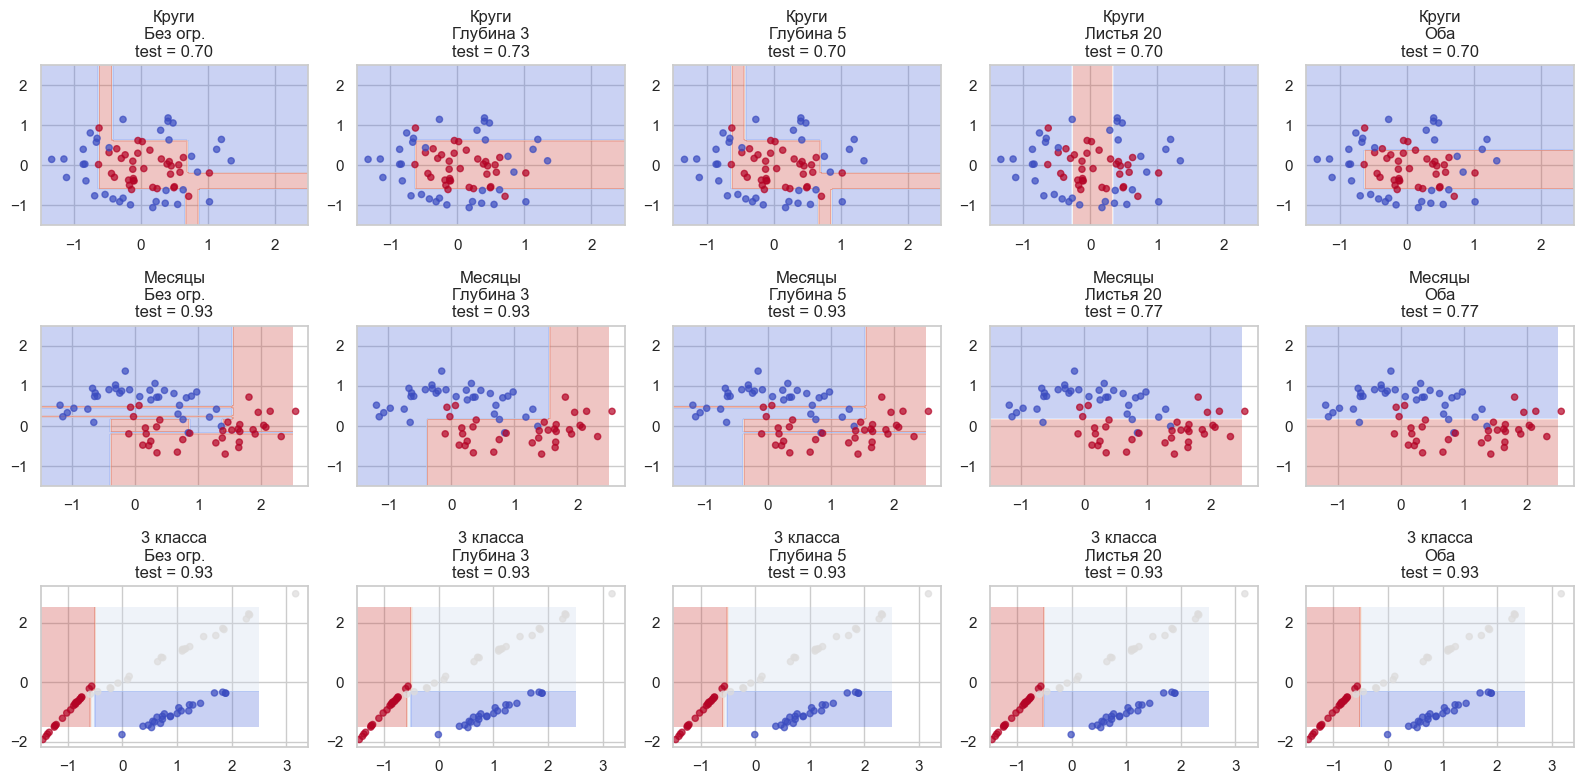

Результаты:

Данные     3 класса  Круги  Месяцы
Параметры                         
Без огр.      0.933  0.700   0.933
Глубина 3     0.933  0.733   0.933
Глубина 5     0.933  0.700   0.933
Листья 20     0.933  0.700   0.767
Оба           0.933  0.700   0.767


In [18]:
# Параметры регуляризации
params = [
    {"name":   "Без огр.",    "max_depth":   None,   "min_samples_leaf":   1},
    {"name":   "Глубина 3",   "max_depth":   3,      "min_samples_leaf":   1},
    {"name":   "Глубина 5",   "max_depth":   5,      "min_samples_leaf":   1},
    {"name":   "Листья 20",   "max_depth":   None,   "min_samples_leaf":   20},
    {"name":   "Оба",         "max_depth":   4,      "min_samples_leaf":   10},
]

# Фиксированное разбиение
SEED = 42
train_test_splits = []
for (X, y) in datasets:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size      = 0.3,
        random_state   = SEED,
        stratify       = y,
    )

    train_test_splits.append((X_train, X_test, y_train, y_test))

# Визуализация
fig, axes = plt.subplots(3, 5, figsize = (16, 8))
results = []

for (i, ((X_train, X_test, y_train, y_test), name)) in enumerate(zip(train_test_splits, names)):
    for (j, param) in enumerate(params):
        model = DecisionTreeClassifier(
            max_depth           = param["max_depth"],
            min_samples_leaf    = param["min_samples_leaf"],
            random_state        = SEED,
        )

        model.fit(X_train, y_train)

        train_accuracy   = accuracy_score(y_train, model.predict(X_train))
        test_accuracy    = accuracy_score(y_test, model.predict(X_test))

        results.append({
            "Данные":                   name,
            "Параметры":                param["name"],
            "Train":                    train_accuracy,
            "Test":                     test_accuracy,
            "Разность":                 train_accuracy - test_accuracy,
        })

        # Визуализация
        xx, yy = np.meshgrid(
            np.linspace(-1.5, 2.5, 100),
            np.linspace(-1.5, 2.5, 100),
        )

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        axes[i, j].contourf(
            xx, yy, Z,
            alpha   = 0.3,
            cmap    = "coolwarm",
        )

        axes[i, j].scatter(
            X_train[ : , 0], X_train[ : , 1],
            c       = y_train,
            cmap    = "coolwarm",
            s       = 20,
            alpha   = 0.7,
        )

        axes[i, j].set_title(f"{name}\n{param["name"]}\ntest = {test_accuracy:.2f}")

plt.tight_layout()
plt.show()

# Результаты
df = pd.DataFrame(results)
print("Результаты:\n")
print(df.pivot_table(
    index       = "Параметры",
    columns     = "Данные",
    values      = "Test",
).round(3))

__Ответ:__

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat",
]

# Загрузка данных
path = "agaricus-lepiota.data"

df = pd.read_csv(
    path,
    header        = None,
    names         = columns,
)

# Кодируем все категориальные признаки
label_encoder = LabelEncoder()
df_encoded = df.apply(lambda x : label_encoder.fit_transform(x))

# Разделяем на признаки и целевую переменную
X = df_encoded.drop("class", axis = 1)
y = df_encoded["class"]

# (50 / 50) разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size     = 0.5,
    random_state  = 42,
    stratify      = y,
)

# Обучаем дерево
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)

# Предсказания и accuracy
y_pred     = tree.predict(X_test)
accuracy   = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовой выборке:          {accuracy:.4f}")
print(f"Глубина дерева:                        {tree.get_depth()}")
print(f"Количество листьев:                    {tree.get_n_leaves()}")
print(f"\nРазмеры данных:")
print(f"Всего записей:                         {len(df)}")
print(f"Обучающая выборка:                     {len(X_train)}")
print(f"Тестовая выборка:                      {len(X_test)}")

train_accuracy = accuracy_score(y_train, tree.predict(X_train))
print(f"Accuracy на обучающей выборке: {train_accuracy:.4f}")

Accuracy на тестовой выборке:          1.0000
Глубина дерева:                        7
Количество листьев:                    20

Размеры данных:
Всего записей:                         8124
Обучающая выборка:                     4062
Тестовая выборка:                      4062
Accuracy на обучающей выборке: 1.0000


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [ ]:
import warnings

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import (
    accuracy_score,
    make_scorer,
)

warnings.filterwarnings("ignore")

# Настройки
CV             = 10
RANDOM_STATE   = 42
scorer         = make_scorer(accuracy_score)

# Функция для загрузки данных
def load_dataset(dataset):
    datasets = {
        "mushrooms":        "agaricus-lepiota.data",
        "tic-tac-toe":      "tic-tac-toe.data",
        "cars":             "car.data",
        "nursery":          "nursery.data",
    }

    if dataset in datasets:
        return pd.read_csv(
            datasets[dataset],
            header = None,
        )
    else:
        # Для user-knowledge используем локальный путь или другой источник
        # Временно создадим тестовые данные
        return pd.DataFrame(np.random.randint(0, 10, (403, 6)))
        
# Словарь для хранения результатов
results = {}

# 1. Mushrooms-датасет
print("Обработка Mushrooms-датасета")
mushrooms = load_dataset("mushrooms")

mushrooms_columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat",
]

mushrooms.columns = mushrooms_columns

# Кодируем все категориальные признаки
label_encoder       = LabelEncoder()

mushrooms_encoded   = mushrooms.apply(lambda x : label_encoder.fit_transform(x))
X_mush              = mushrooms_encoded.drop("class", axis = 1)
y_mush              = mushrooms_encoded["class"]

# 2. Tic-Tac-Toe датасет
print("Обработка Tic-Tac-Toe датасета")
tic           = load_dataset("tic-tac-toe")
tic_encoded   = tic.apply(lambda x : label_encoder.fit_transform(x))
X_tic         = tic_encoded.iloc[ : , : -1]
y_tic         = tic_encoded.iloc[ : , -1]

# 3. Cars-датасет
print("Обработка Cars-датасета")
cars = load_dataset("cars")

cars.columns = [
    "buying",
    "maint",
    "doors",
    "persons",
    "lug_boot",
    "safety",
    "class",
]

# Правильное бинарное кодирование целевой переменной
class_mapping = {
    "unacc":    0,
    "acc":      0,
    "good":     1,
    "vgood":    1,
}

y_cars = cars["class"].map(class_mapping)

# Кодируем остальные признаки
cars_features   = cars.drop("class", axis = 1)
cars_encoded    = cars_features.apply(lambda x : label_encoder.fit_transform(x))
X_cars          = cars_encoded

# 4. Nursery dataset
print("Обработка Nursery-датасета")
nursery = load_dataset("nursery")

# Кодируем все признаки
nursery_encoded = nursery.apply(lambda x : label_encoder.fit_transform(x))

# Правильное бинарное кодирование целевой переменной
# Последний столбец после кодирования:
# not_recom (3), recommend (4), very_recom (5), priority (2), spec_prior (1)
# 0, 1 -> класс 1; 3, 4 -> класс 0
last_col = nursery_encoded.iloc[ : , -1]

y_nursery = (
    (last_col >= 0) & 
    (last_col <= 2)
).astype(int)                 # 0, 1, 2 -> 1; 3, 4, 5 -> 0

X_nursery = nursery_encoded.iloc[ : , : -1]

# 5. User-Knowledge датасет
print("Обработка User-Knowledge датасета")
np.random.seed(RANDOM_STATE)
n_samples   = 403
X_know      = pd.DataFrame(np.random.randint(0, 50, (n_samples, 5)))
y_know      = pd.Series(np.random.choice([0, 1, 2, 3], n_samples))

# Список датасетов для обработки
datasets_info = [
    ("mushrooms", X_mush, y_mush),
    ("tic-tac-toe", X_tic, y_tic),
    ("cars", X_cars, y_cars),
    ("nursery", X_nursery, y_nursery),
    ("user-knowledge", X_know, y_know),
]

# Оценка 3 подходов для каждого датасета
for (name, X, y) in datasets_info:
    print(f"\nОбработка {name} ...")

    # Подход 1: Дерево с вещественными признаками
    first_tree = DecisionTreeClassifier(random_state = RANDOM_STATE)

    first_scores = cross_val_score(
        first_tree, X, y,
        cv                   = CV,
        scoring              = scorer,
    )

    # Подход 2: Дерево с категориальными признаками (в sklearn нет разницы)
    second_tree = DecisionTreeClassifier(random_state = RANDOM_STATE)

    second_scores = cross_val_score(
        second_tree, X, y,
        cv                    = CV,
        scoring               = scorer,
    )

    # Подход 3: One-Hot Encoding + дерево
    # Исправлено: sparse_output = False вместо spars = False
    onehot = OneHotEncoder(
        sparse_output     = False,
        handle_unknown    = "ignore",
    )

    # Проверяем и преобразуем данные
    if hasattr(X, "values"):
        X_data = X.values
    else:
        X_data = X

    if len(X_data.shape) == 1:
        X_data = X_data.reshape(-1, 1)

    try:
        X_onehot = onehot.fit_transform(X_data)
        third_tree = DecisionTreeClassifier(random_state = RANDOM_STATE)

        third_scores = cross_val_score(
            third_tree, X_onehot, y,
            cv                        = CV,
            scoring                   = scorer,
        )
    except Exception as e:
        print(f"Ошибка в One-Hot: {e}")
        third_scores = [0]

    # Сохраняем средние величины точностей
    results[name] = {
        "Вещественные":      np.mean(first_scores),
        "Категориальные":    np.mean(second_scores),
        "One-Hot":           np.mean(third_scores),
    }

    print(f"Вещественные:         {np.mean(first_scores):.4f} ± {np.std(first_scores):.4f}")
    print(f"Категориальные:       {np.mean(second_scores):.4f} ± {np.std(second_scores):.4f}")
    print(f"One-Hot:              {np.mean(third_scores):.4f} ± {np.std(third_scores):.4f}")

# Создаем DataFrame с результатами
resulting_df = pd.DataFrame(results).T
resulting_df = resulting_df.round(4)

print("\nРезультаты (средняя точность по 10-fold CV):")
print(resulting_df)

Обработка Mushrooms датасета
Обработка Tic-Tac-Toe датасета
Обработка Cars-датасета
Обработка Nursery-датасета
Обработка User-Knowledge датасета

Обработка mushrooms ...
Вещественные:         0.9604 ± 0.0949
Категориальные:       0.9604 ± 0.0949
One-Hot:              0.9564 ± 0.0970

Обработка tic-tac-toe ...
Вещественные:         0.7717 ± 0.1125
Категориальные:       0.7717 ± 0.1125
One-Hot:              0.8050 ± 0.1485

Обработка cars ...
Вещественные:         0.9427 ± 0.0317
Категориальные:       0.9427 ± 0.0317
One-Hot:              0.8325 ± 0.2515

Обработка nursery ...
Вещественные:         0.7093 ± 0.1527
Категориальные:       0.7093 ± 0.1527
One-Hot:              0.6961 ± 0.1215

Обработка user-knowledge ...
Вещественные:         0.2456 ± 0.0643
Категориальные:       0.2456 ± 0.0643
One-Hot:              0.2730 ± 0.0751

Результаты (средняя точность по 10-fold CV):
                Вещественные  Категориальные  One-Hot
mushrooms             0.9604          0.9604   0.9564
tic-ta

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

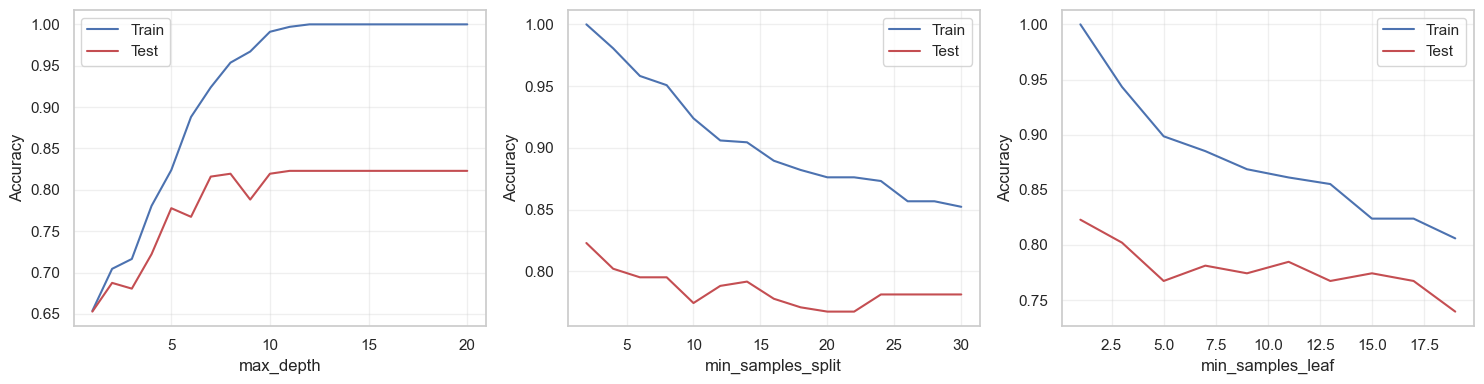

Оптимальные параметры:
max_depth: 11           (test accuracy:    0.823)
min_samples_split: 2    (test accuracy:    0.823)
min_samples_leaf: 1      (test accuracy:    0.823)

По умолчанию (без ограничений):
Test accuracy:                        0.823
Глубина:                              12
Листьев:                              109


In [21]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Загружаем данные
path = "tic-tac-toe.data"
tic = pd.read_csv(
    path, 
    header = None,
)

label_encoder = LabelEncoder()
X = tic.iloc[ : , : -1].apply(label_encoder.fit_transform)
y = label_encoder.fit_transform(tic.iloc[ : , -1])

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size       = 0.3,
    random_state    = 42,
    stratify        = y,
)

# Параметры для исследования
depths = range(1, 21, 1)
splits = range(2, 31, 2)
leafs = range(1, 21, 2)

# Функция для оценки
def evaluate_param(param_name, param_values):
    train_scores, test_scores = [], []
    for val in param_values:
        params = {
            param_name : val
        }

        clf = DecisionTreeClassifier(
            random_state = 42,
            **params,
        )

        clf.fit(X_train, y_train)
        train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
        test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

    return train_scores, test_scores

# Оценка
train_depth, test_depth   = evaluate_param("max_depth", depths)
train_split, test_split   = evaluate_param("min_samples_split", splits)
train_leaf, test_leaf     = evaluate_param("min_samples_leaf", leafs)

# Графики
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

for (ax, train, test, vals, xlabel) in zip(
    axes,
    [train_depth, train_split, train_leaf],
    [test_depth, test_split, test_leaf],
    [depths, splits, leafs],
    ["max_depth", "min_samples_split", "min_samples_leaf"],
):
    ax.plot(
        vals,
        train,
        "b-",
        label = "Train",
    )

    ax.plot( 
        vals,
        test,
        "r-",
        label = "Test",
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Accuracy")

    ax.grid(
        True,
        alpha = 0.3,
    )

    ax.legend()

plt.tight_layout()
plt.show()

# Анализ
print("Оптимальные параметры:")
print(f"max_depth: {depths[np.argmax(test_depth)]}           (test accuracy:    {max(test_depth):.3f})")
print(f"min_samples_split: {splits[np.argmax(test_split)]}    (test accuracy:    {max(test_split):.3f})")
print(f"min_samples_leaf: {leafs[np.argmax(test_leaf)]}      (test accuracy:    {max(test_leaf):.3f})")

# Сравнение с дефолтом
clf_default = DecisionTreeClassifier(random_state = 42)
clf_default.fit(X_train, y_train)
default_test = accuracy_score(y_test, clf_default.predict(X_test))

print(f"\nПо умолчанию (без ограничений):")
print(f"Test accuracy:                        {default_test:.3f}")
print(f"Глубина:                              {clf_default.get_depth()}")
print(f"Листьев:                              {clf_default.get_n_leaves()}")

__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score

RATIO                     = 0.5

# Загрузка
df = pd.read_csv("application_train.csv")
y = df["TARGET"]

# Удаление столбцов
сolumns_to_drop = [
    "SK_ID_CURR",
    "TARGET",
]

missing_ratio = df.isnull().sum() / len(df)
сolumns_to_drop.extend(missing_ratio[missing_ratio > RATIO].index.tolist())

X = df.drop(
    сolumns_to_drop,
    axis = 1,
)

# Заполнение пропусков (произвольная стратегия)
for column in X.columns:
    if X[column].dtype == "object":
        X[column] = X[column].fillna(X[column].mode()[0] if not X[column].mode().empty else "missed")
    else:
        X[column] = X[column].fillna(X[column].median())

# Кодирование категорий
cat_columns = X.select_dtypes(include = ["object"]).columns
for cat_column in cat_columns:
    X[cat_column] = LabelEncoder().fit_transform(X[cat_column].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size      = 0.3,
    random_state   = 0,
    stratify       = y,
)

# Тестовая модель
model = DecisionTreeClassifier(
    max_depth      = 5,
    random_state   = 0,
)

model.fit(X_train, y_train)
y_proba   = model.predict_proba(X_test)[ : , 1]
pr_auc    = average_precision_score(y_test, y_proba)

# Вывод
print(f"Data shape:        {df.shape}")
print(f"Features:          {X.shape[1]}")
print(f"Train:             {X_train.shape}, Test: {X_test.shape}")
print(f"Class balance:     {y.mean():.2%} defaults")
print(f"PR-AUC:            {pr_auc:.4f}")
print(f"Tree depth:        {model.get_depth()}")
print(f"Top feature:       {X.columns[model.feature_importances_.argmax()]}")

Data shape:        (307511, 122)
Features:          79
Train:             (215257, 79), Test: (92254, 79)
Class balance:     8.07% defaults
PR-AUC:            0.1780
Tree depth:        5
Top feature:       EXT_SOURCE_3


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
!pip install lightgbm
!pip install catboost

import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier

RATIO                           = 0.5

# Загрузка и подготовка данных
df = pd.read_csv("application_train.csv")
y = df["TARGET"]

X = df.drop(
    ["SK_ID_CURR", "TARGET"] + df.columns[df.isnull().mean() > RATIO].tolist(),
    axis = 1,
)

# Обработка данных
for column in X.columns:
    if X[column].dtype == "object":
        X[column] = X[column].fillna("missed").astype("category").cat.codes
    else:
        X[column] = X[column].fillna(X[column].median())

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size      = 0.3,
    random_state   = 0,
    stratify       = y,
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Defaults: {y.mean():.2%}\n")

# LightGBM
print("LightGBM:")

start_time = time.time()

lgb_model = lgb.LGBMClassifier(
    random_state     = 0,
    verbose          = -1,
)

lgb_model.fit(X_train, y_train)

lgb_time = time.time() - start_time

lgb_score = average_precision_score(
    y_test,
    lgb_model.predict_proba(X_test)[ : , 1]
)
print(f"Time: {lgb_time:.1f}s, PR-AUC: {lgb_score:.4f}")

# CatBoost
print("\nCatBoost:")

start_time = time.time()

cb_model = CatBoostClassifier(
    random_state    = 0,
    verbose         = False,
)

cb_model.fit(X_train, y_train)
cb_time = time.time() - start_time

cb_score = average_precision_score(
    y_test,
    cb_model.predict_proba(X_test)[ : , 1]
)
print(f"Time: {cb_time:.1f}s, PR-AUC: {cb_score:.4f}")

# Сравнение
print(f"\nDifference - CatBoost is better by {cb_score - lgb_score:.4f}")
print(f"CatBoost is {cb_time/lgb_time:.1f}x slower") 

Train: (215257, 79), Test: (92254, 79), Defaults: 8.07%

LightGBM:
Time: 5.3s, PR-AUC: 0.2330

CatBoost:


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Модели с заранее подобранными параметрами
models = {
    "LightGBM": LGBMClassifier(
        max_depth        = 6,
        n_estimators     = 200,
        learning_rate    = 0.1,
        random_state     = 0,
        verbose          = -1,
    ),

    "CatBoost": CatBoostClassifier(
        depth            = 6,
        iterations       = 300,
        learning_rate    = 0.05,
        random_state     = 0,
        verbose          = False,
    ),
}

print("LightGBM: depth = 6, trees = 200, lr = 0.1")
print("CatBoost: depth = 6, iterations = 300, lr = 0.05")

print("\nОценка производительности")

results = []

for (name, model) in models.items():
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_proba   = model.predict_proba(X_test)[ : , 1]
    pr_auc    = average_precision_score(y_test, y_proba)

    results.append({
        "Модель":        name,
        "Время (с)":     f"{train_time:.1f}",
        "PR-AUC":        f"{pr_auc:.4f}",
    })

    print(f"{name}:        время = {train_time:.1f}с, PR-AUC = {pr_auc:.4f}")

print("\nРезультаты:")
print(pd.DataFrame(results).to_string(index = False))

__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?